# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>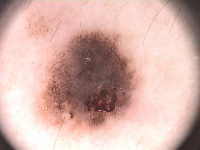</td><td>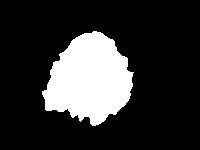</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-09-11 06:40:03--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-09-11 06:40:03--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc2e3edbb7af0a07c1471cf457f.dl.dropboxusercontent.com/cd/0/inline/A_IBZsfWr5Hcm3KbUhbvzb6CUQnJAwjyDez_dnVS75VkyJhxUKB0IB6VIoTmBeyAHgXc8cZyT8TN3t6hZwCqVonws5tCw04-UotKKxxOvjRKfA/file# [following]
--2020-09-11 06:40:03--  https://ucc2e3edbb7af0a07c1471cf457f.dl.dropboxusercontent.com/cd/0/inline/A_IBZsfWr5Hcm3KbUhbvzb6CUQnJAwjyDez_dnVS75VkyJhxUKB0IB6VIoTmBeyAHgXc8cZyT8TN3t6hZwCqVonws5tCw04-UotKKxxOvjRKfA/file
Resolving ucc

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

In [7]:
Y.shape

(200, 256, 256)

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

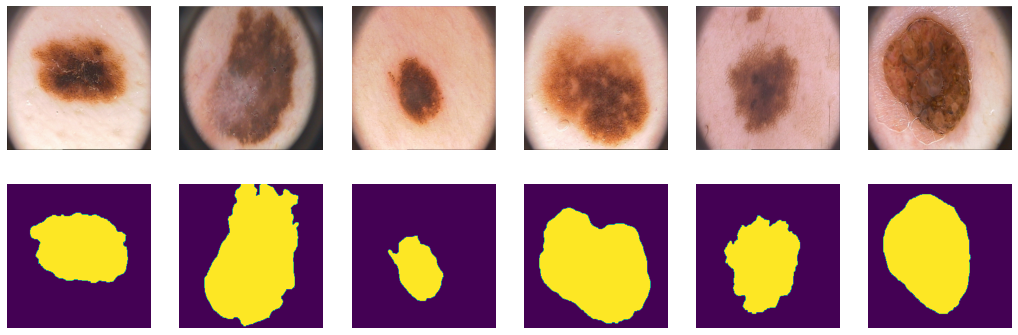

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
Y[tr, np.newaxis].shape

(100, 1, 256, 256)

In [13]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

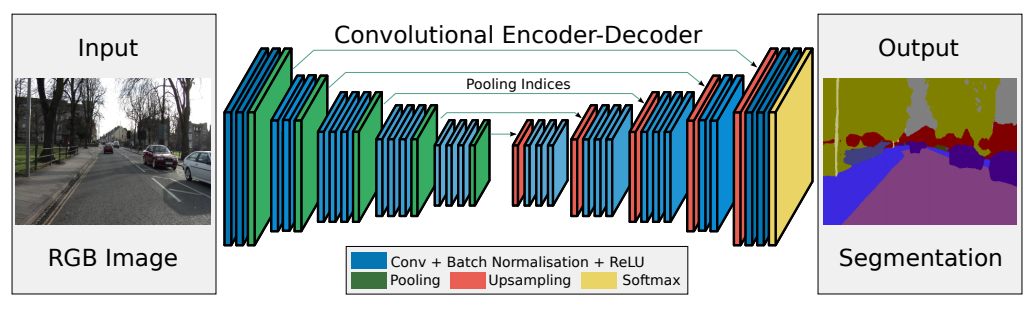

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 =  nn.Sequential(
            *[nn.Conv2d(3, 32, kernel_size=3, padding=1)] + 
              [nn.Conv2d(32, 32, kernel_size=3, padding=1),
               nn.BatchNorm2d(32),
               nn.ReLU(inplace=True)]) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
        
        self.enc_conv1 =  nn.Sequential(
            *[nn.Conv2d(32, 64, kernel_size=3, padding=1)] + 
              [nn.Conv2d(64, 64, kernel_size=3, padding=1),
               nn.BatchNorm2d(64),
               nn.ReLU(inplace=True)]) 
        
        self.enc_conv2 =  nn.Sequential(
            *[nn.Conv2d(64, 128, kernel_size=3, padding=1)] + 
              [nn.Conv2d(128, 128, kernel_size=3, padding=1),
               nn.Conv2d(128, 128, kernel_size=3, padding=1),
               nn.BatchNorm2d(128),
               nn.ReLU(inplace=True)])

        self.enc_conv3 =  nn.Sequential(
            *[nn.Conv2d(128, 256, kernel_size=3, padding=1)] + 
              [nn.Conv2d(256, 256, kernel_size=3, padding=1),
               nn.Conv2d(256, 256, kernel_size=3, padding=1),
               nn.BatchNorm2d(256),
               nn.ReLU(inplace=True)]) 

        # # bottleneck
        self.bottleneck_conv = nn.Sequential(
            *[nn.Conv2d(256, 512, kernel_size=3, padding=1)] + 
              [nn.Conv2d(512, 512, kernel_size=3, padding=1),
               nn.Conv2d(512, 512, kernel_size=3, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(inplace=True)]) 

        # # decoder (upsampling)
        self.upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            *[nn.Conv2d(512, 512, kernel_size=3, padding=1)] + 
              [nn.Conv2d(512, 512, kernel_size=3, padding=1),
               nn.Conv2d(512, 256, kernel_size=3, padding=1),
               nn.BatchNorm2d(256),
               nn.ReLU(inplace=True)]) 
        self.dec_conv1 = nn.Sequential(
            *[nn.Conv2d(256, 256, kernel_size=3, padding=1)] + 
              [nn.Conv2d(256, 256, kernel_size=3, padding=1),
               nn.Conv2d(256, 128, kernel_size=3, padding=1),
               nn.BatchNorm2d(128),
               nn.ReLU(inplace=True)])
        self.dec_conv2 = nn.Sequential(
            *[nn.Conv2d(128, 128, kernel_size=3, padding=1)] + 
              [nn.Conv2d(128, 128, kernel_size=3, padding=1),
               nn.Conv2d(128, 64, kernel_size=3, padding=1),
               nn.BatchNorm2d(64),
               nn.ReLU(inplace=True)])
        self.dec_conv3 = nn.Sequential(
            *[nn.Conv2d(64, 64, kernel_size=3, padding=1)] + 
              [nn.Conv2d(64, 32, kernel_size=3, padding=1),
               nn.BatchNorm2d(32),
               nn.ReLU(inplace=True)])
        self.dec_conv4 = nn.Sequential(
            *[nn.Conv2d(32, 32, kernel_size=3, padding=1)] + 
               [nn.Conv2d(32, 1, kernel_size=3, padding=1)])


    def forward(self, x):
        # # encoder
        e0, id0 = self.pool(self.enc_conv0(x))
        e1, id1 = self.pool(self.enc_conv1(e0))
        e2, id2 = self.pool(self.enc_conv2(e1))
        e3, id3 = self.pool(self.enc_conv3(e2))

        # # bottleneck
        b, id4 = self.pool(self.bottleneck_conv(e3))

        # # decoder
        d0 = self.dec_conv0(self.upsample(b, id4))
        d1 = self.dec_conv1(self.upsample(d0, id3))
        d2 = self.dec_conv2(self.upsample(d1, id2))
        d3 = self.dec_conv3(self.upsample(d2, id1))
        d4 = self.dec_conv4(self.upsample(d3, id0))

        return d4 

In [16]:
from torchsummary import summary # чтобы смотреть описание мордели и ее параметров как в keras

model = SegNet().to(device)
summary(model, input_size=(3, 256, 256)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
            Conv2d-2         [-1, 32, 256, 256]           9,248
       BatchNorm2d-3         [-1, 32, 256, 256]              64
              ReLU-4         [-1, 32, 256, 256]               0
         MaxPool2d-5  [[-1, 32, 128, 128], [-1, 32, 128, 128]]               0
            Conv2d-6         [-1, 64, 128, 128]          18,496
            Conv2d-7         [-1, 64, 128, 128]          36,928
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10  [[-1, 64, 64, 64], [-1, 64, 64, 64]]               0
           Conv2d-11          [-1, 128, 64, 64]          73,856
           Conv2d-12          [-1, 128, 64, 64]         147,584
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNo

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    outputs[outputs < 0.9 ] = 0
    outputs[outputs >= 0.9 ] = 1
    intersection = (outputs & labels).float().sum((1, 2))# Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return  iou 

## функция лосса

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_real, y_pred):
    bce = (y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))).mean()
    return bce

## Тренировка 

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        X_batch_hat = X_batch.detach().to('cpu')
        Y_train_hat = Y_batch.detach().to('cpu')
        Y_pred = torch.sigmoid(Y_pred)
        Y_hat = Y_pred.detach().to('cpu') # detach and put into cpu

        Y_hat[Y_hat < 0.9 ] = 0

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_batch_hat[k].numpy(), 0, 3), cmap='gray') 
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_train_hat[k, 0])
            plt.title('Expected mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0])            
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()


## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
def predict(model, data):
    with torch.no_grad():
      model.eval()  # testing mode
      Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [21]:
Y_pred = [X_batch for X_batch, _ in data_val]

In [22]:
def score_model(model, metric, data):
  with torch.no_grad():
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred.to('cpu'), Y_label).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [23]:
model = SegNet().to(device)

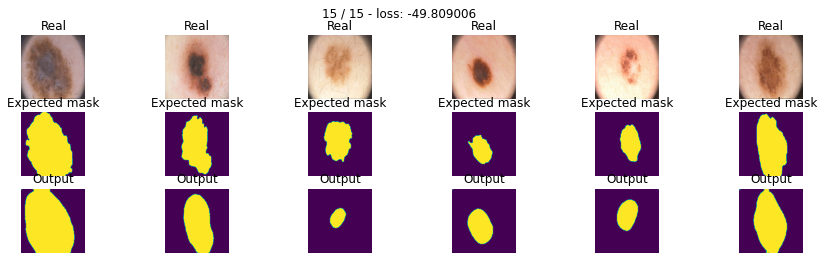

In [24]:
max_epochs = 15

optim = torch.optim.Adam(model.parameters())
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [25]:
score_model(model, iou_pytorch,data_val)

0.3215263783931732

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [26]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    y_pred = torch.sigmoid(y_pred)
    num = (y_real * y_pred).sum() + SMOOTH
    den = y_real.sum() + y_pred.sum() + SMOOTH
    res = 1 - 2*num/den/0.000015 
    return res 

Проводим тестирование:

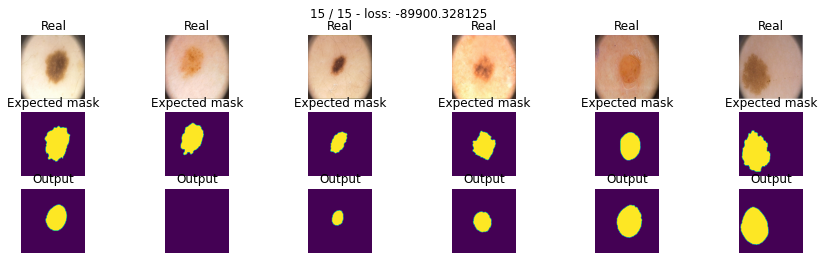

In [27]:
model_dice = SegNet().to(device)

max_epochs = 15
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [28]:
score_model(model_dice, iou_pytorch, data_val)

0.6407018303871155

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [29]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    f_loss = ((1 - y_pred)**gamma) * y_real * torch.log(y_pred+eps) + (1-y_real) * torch.log(1-y_pred+eps)
    return - torch.mean(f_loss)


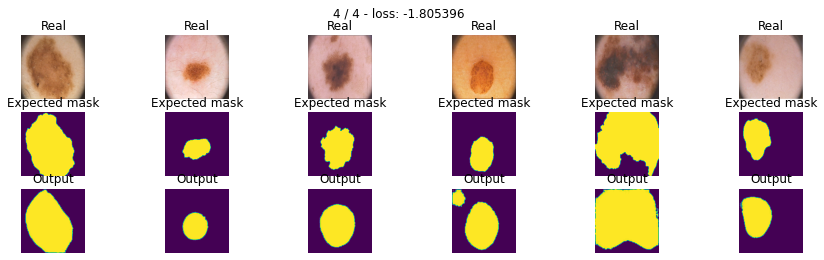

In [35]:
model_focal = SegNet().to(device)

max_epochs = 4
optimaizer = torch.optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [36]:
score_model(model_focal, iou_pytorch, data_val)

0.4159189909696579